In [135]:
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from torch.nn import MSELoss
from itertools import combinations

In [136]:
landmarks = 6
individual_goals = np.eye(landmarks, dtype=np.uint8).tolist()
goals = (
    np.array(list(combinations(individual_goals, 2))).sum(1).tolist()
)


In [142]:
goals_dim = len(goals[0])
n_goals = len(goals)
sender = torch.nn.Sequential(torch.nn.Linear(goals_dim,64), torch.nn.ReLU(), torch.nn.Linear(64,n_goals))
optimizer = Adam(sender.parameters(), lr=0.0003)
criterion = MSELoss()

In [143]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


low_r = get_truncated_normal(mean=0.25, sd=0.25, low=0, upp=1)
high_r = get_truncated_normal(mean=1.0, sd=0.25, upp=1, low=0)
rewards = torch.tensor([])
losses = []
input_goals = torch.empty([100, 6])
output_goal_index = []
j = 0
for t in range(200_000):
    # interact
    sampled_goal = goals[np.random.randint(0, n_goals)]
    prediction = sender(torch.tensor(sampled_goal, dtype=torch.float))
    input_goals[j] = torch.tensor(sampled_goal, dtype=torch.float)
    # epsilon-greedy
    if np.random.random() < 0.1:
        message = np.random.randint(0, n_goals)
    else:
        message = prediction.argmax().item()
    output_goal_index.append(message)
    value = prediction[message].view(1)
    other_goal = goals[message]
    if other_goal == sampled_goal:
        reward = torch.unsqueeze(torch.tensor(high_r.rvs().astype(np.float32)), 0)
    else:
        reward = torch.unsqueeze(torch.tensor(low_r.rvs().astype(np.float32)), 0)
    rewards = torch.cat([rewards, reward])
    j += 1
    # learn
    if t !=0 and t % 99==0:
        rewards = rewards.unsqueeze(-1)
        for i in range(20):
            vs = sender(input_goals).gather(1, torch.tensor(output_goal_index).view(-1,1))
            optimizer.zero_grad()
            loss = criterion(vs, rewards)
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach().item())
        rewards = torch.tensor([])
        input_goals = torch.empty([100, 6])
        output_goal_index = []
        j = 0


In [150]:
a = []
for i in input_goals:
    a.append(i)
a

[tensor([0., 1., 0., 1., 0., 0.]),
 tensor([0., 0., 1., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 0., 0.]),
 tensor([0., 0., 0., 1., 0., 1.]),
 tensor([0., 0., 0., 0., 1., 1.]),
 tensor([0., 0., 0., 1., 1., 0.]),
 tensor([0., 1., 0., 0., 1., 0.]),
 tensor([0., 1., 0., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 1., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 1.]),
 tensor([0., 0., 1., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 1., 0.]),
 tensor([0., 0., 0., 1., 0., 1.]),
 tensor([1., 0., 0., 0., 1., 0.]),
 tensor([1., 1., 0., 0., 0., 0.]),
 tensor([0., 1., 0., 1., 0., 0.]),
 tensor([0., 0., 0., 0., 1., 1.]),
 tensor([0., 1., 0., 0., 1., 0.]),
 tensor([0., 1., 0., 1., 0., 0.]),
 tensor([0., 0., 0., 1., 0., 1.]),
 tensor([0., 0., 1., 0., 1., 0.]),
 tensor([1., 0., 0., 1., 0., 0.]),
 tensor([0., 0., 1., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 1., 0.]),
 tensor([0., 1., 0.,

In [141]:
len(output_goal_index)

199

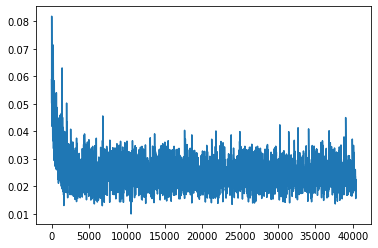

In [144]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [145]:
for i,goal in enumerate(goals):
    print(f"Same goal index {i}, selected goal: {sender(torch.tensor(goal, dtype=torch.float)).argmax()}")


Same goal index 0, selected goal: 0
Same goal index 1, selected goal: 1
Same goal index 2, selected goal: 2
Same goal index 3, selected goal: 3
Same goal index 4, selected goal: 4
Same goal index 5, selected goal: 5
Same goal index 6, selected goal: 6
Same goal index 7, selected goal: 7
Same goal index 8, selected goal: 8
Same goal index 9, selected goal: 9
Same goal index 10, selected goal: 10
Same goal index 11, selected goal: 11
Same goal index 12, selected goal: 12
Same goal index 13, selected goal: 13
Same goal index 14, selected goal: 14
